In [17]:
import torch
from torch import nn
import os
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [18]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
model = SimpleCNN()
model_path = r"C:\Users\USER\Desktop\Projects\PASD_Deteksi_Penyakit_Tanaman\Model\[] current_model\cnn-tomato_disease-20250205.pth"
checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
dir_test = r"C:\Users\USER\Desktop\Projects\PASD_Deteksi_Penyakit_Tanaman\Dataset_Classification\test_old"

image_size = (224, 224)

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(root=dir_test, transform=test_transform)

test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=0
)

In [21]:
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to("cpu"), labels.to("cpu")
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

In [24]:
class_names = os.listdir(dir_test)
conf_matrix = confusion_matrix(all_labels, all_preds)

In [25]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9747
Precision: 0.9746
Recall: 0.9747
F1 Score: 0.9745

Classification Report:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.97      0.99      0.98       212
                        Tomato___Early_blight       0.90      0.84      0.87       100
                             Tomato___healthy       0.94      0.98      0.96       191
                         Tomato___Late_blight       1.00      0.98      0.99        95
                           Tomato___Leaf_Mold       0.96      0.97      0.96       177
                  Tomato___Septoria_leaf_spot       0.97      0.98      0.97       168
Tomato___Spider_mites Two-spotted_spider_mite       0.97      0.95      0.96       141
                         Tomato___Target_Spot       1.00      0.99      1.00       535
                 Tomato___Tomato_mosaic_virus       0.95      1.00      0.97        38
       Tomato___Tomato_Yellow_Leaf_Cur

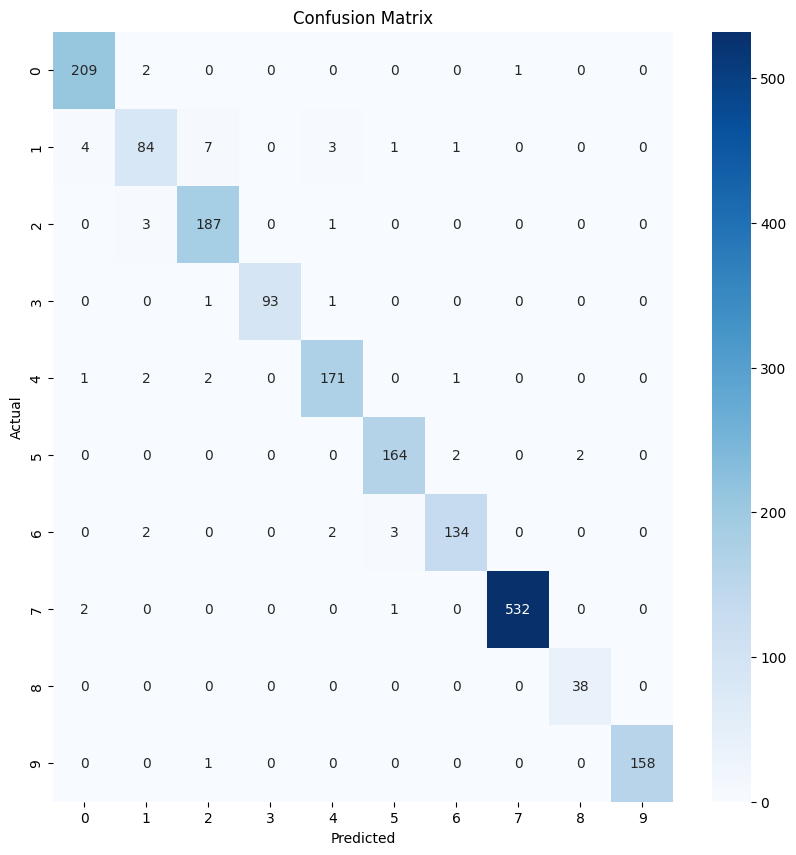

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix")
plt.show()